In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.pandas import PandasDataset, is_uniform, infer_freq
from gluonts.dataset.split import split, TestData
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.eval_util.evaluation import evaluate_model
from gluonts.ev.metrics import MAE, MAPE

from mov_av import moving_average
from uni2ts.alex.common.benchmark_func import *

In [2]:
it_data_23_24 = pd.read_csv('data/it_load_data_23_24.csv', delimiter=',')
it_data_23_24['DateUTC'] = pd.to_datetime(it_data_23_24['DateUTC'])
it_data_23_24 = it_data_23_24.set_index('DateUTC')

## Stage 2 Finetuning method comparison

For the second round of finetuning, there are 3 different ways that it can happen:

- Having the model from Stage 1 we start the training using this model. After the 1st training iteration ends we save the modified model and use it on the next iteration and so on ... In training iteration N we use the trained model from iteraion N-1. (refit_t_thorough_f)
- At every training iteration we use as a starting model the Stage 1 model, which we further finetune with the all the available data up to that point. (refit_f_thorough_f)

In both of the afrementioned methods we only perform 1 backward pass of the available data.

- At every training iteration we use as a starting model the Stage 1 model, which we further finetune with the all the available data up to that point for more than 1 epochs (slightly different training configuration). (refit_f_thorough_t)

For example, in the pictre below our case is shown. The difference between the first method and the other two is the model with which we start each training iteration. In the first we use a different one each time, but in the other two we use the same model and only data change.

![](https://miro.medium.com/v2/resize:fit:1400/0*E0xyoKfV9p5nOhTF.png)

In [3]:
def get_metrics_v2(model_folder: str, data: pd.DataFrame):
    metrics = {"mean": [], "median": [], "lower_0025": [], "upper_0975": []}
    for i in range(1, 52):
        try:
            model, test_data = get_model_data(
                                    model_folder=model_folder,
                                    prediction_lenght=168,
                                    num_of_weeks=i,
                                    data=data,
                                    patch_size="auto",
                                    num_samples=500,
                                )
            
            forecast_samples, target_values = get_eval_foreasts(model, test_data)
    
            # absolute error of the average forecast of each time step
            mean_error_ts = (np.mean(forecast_samples, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            mean_error_ts = np.abs(mean_error_ts)
    
            # absolute error of the median forecast of each time step
            median_error_ts = (np.quantile(forecast_samples, 0.5, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            median_error_ts = np.abs(median_error_ts)
    
            # absolute error of the 97.5th percentile forecast of each time step
            upper_error_ts = (np.quantile(forecast_samples, 0.975, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            upper_error_ts = np.abs(upper_error_ts)
    
            # absolute error of the 2.5th percentile forecast of each time step
            lower_error_ts = (np.quantile(forecast_samples, 0.025, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            lower_error_ts = np.abs(lower_error_ts)
    
            metrics['mean'].append(mean_error_ts)
            metrics['median'].append(median_error_ts)
            metrics['lower_0025'].append(lower_error_ts)
            metrics['upper_0975'].append(upper_error_ts)
            
        except:
            pass

    return metrics

In [4]:
data = it_data_23_24

model_folder = "outputs/finetune/moirai_small/refit_t_thorough_f/checkpoints/it_load_data_train_"
backtesting_with_refit = get_metrics_v2(model_folder, data)

model_folder = "outputs/finetune/moirai_small/refit_f_thorough_f/checkpoints/it_load_data_train_"
refit_1_pass =  get_metrics_v2(model_folder, data)

model_folder = "outputs/finetune/moirai_small/refit_f_thorough_t/checkpoints/it_load_data_train_"
refit_multiple_passes = get_metrics_v2(model_folder, data)

model_folder = "outputs/finetune/moirai_small/refit_f_thorough_t_dropout_01/checkpoints/it_load_data_train_"
refit_multiple_passes_v2 = get_metrics_v2(model_folder, data)

model_folder = "pretrained"
pretrained = get_metrics_v2(model_folder, data)

In [5]:
backtesting_with_refit = pd.DataFrame.from_dict(backtesting_with_refit)
refit_1_pass = pd.DataFrame.from_dict(refit_1_pass)
refit_multiple_passes = pd.DataFrame.from_dict(refit_multiple_passes)
refit_multiple_passes_v2 = pd.DataFrame.from_dict(refit_multiple_passes_v2)
pretrained = pd.DataFrame.from_dict(pretrained)

As far as the 3rd method is concerned, mutliple backward passes, one would think why not try different dropout levels as well to determine a little more optimized approach. The plot below examines exactly that and it seems that dropout doesn't improve performance in our situation. So in the later comparisons we only include the method without dropout.

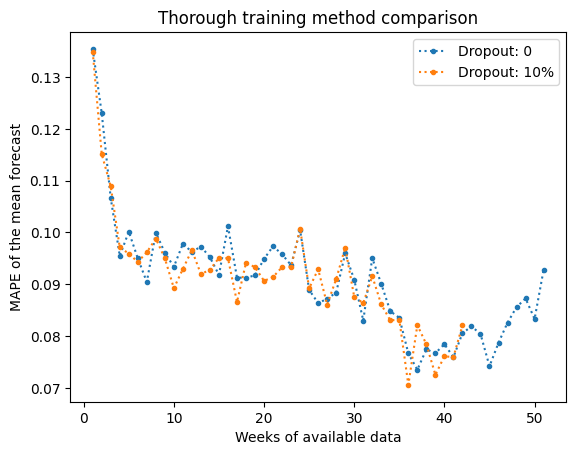

In [6]:
# MAPE of the average forecast
plt.title("Thorough training method comparison")
plt.ylabel("MAPE of the mean forecast")
plt.xlabel("Weeks of available data")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="Dropout: 0%")
plt.errorbar(x=range(1, 43), y=[np.mean(ts) for ts in refit_multiple_passes_v2['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="Dropout: 10%")
plt.legend()
plt.savefig("experiment_results/stage_2_finetune_method_comp/thorough_training_method_comparison.jpeg");

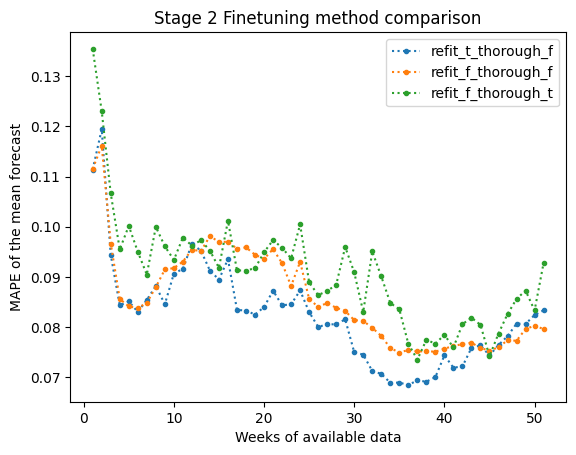

In [7]:
# MAPE of the average forecast
plt.title("Stage 2 Finetuning method comparison")
plt.ylabel("MAPE of the mean forecast")
plt.xlabel("Weeks of available data")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in backtesting_with_refit['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_t_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_1_pass['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t")
plt.legend();
plt.savefig("experiment_results/stage_2_finetune_method_comp/stage_2_finetune_method_comp_mean.jpeg");

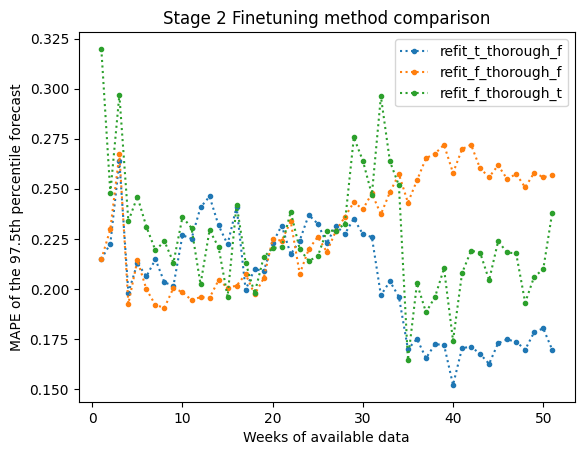

In [8]:
# MAPE of the 97.5th percentile forecast
plt.title("Stage 2 Finetuning method comparison")
plt.ylabel("MAPE of the 97.5th percentile forecast")
plt.xlabel("Weeks of available data")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in backtesting_with_refit['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_t_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_1_pass['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t")
plt.legend();
plt.savefig("experiment_results/stage_2_finetune_method_comp/stage_2_finetune_method_comp_975.jpeg");

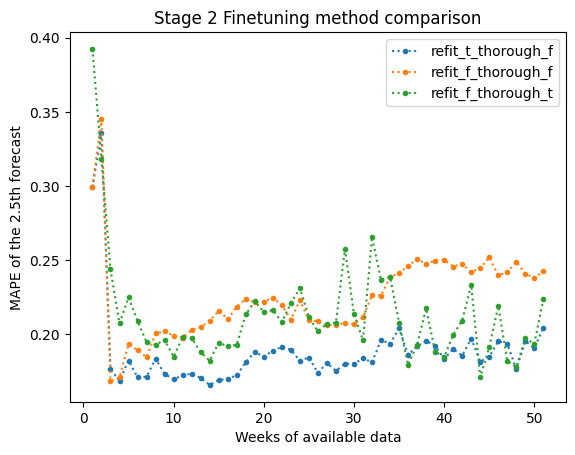

In [9]:
# MAPE of the 2.5th percentile forecast
plt.title("Stage 2 Finetuning method comparison")
plt.ylabel("MAPE of the 2.5th forecast")
plt.xlabel("Weeks of available data")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in backtesting_with_refit['lower_0025'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_t_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_1_pass['lower_0025'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['lower_0025'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t")
plt.legend()
plt.savefig("experiment_results/stage_2_finetune_method_comp/stage_2_finetune_method_comp_025.jpeg");

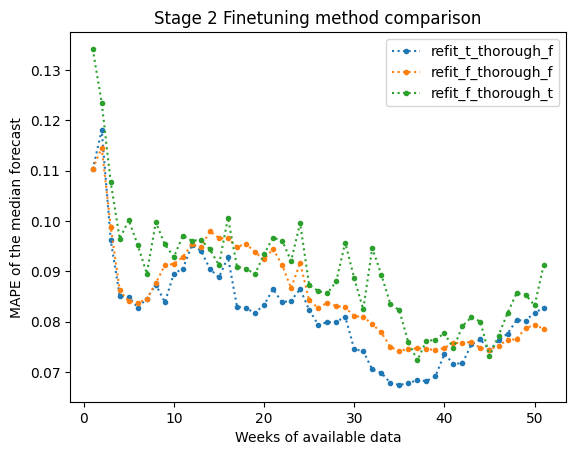

In [10]:
# MAPE of the median forecast
plt.title("Stage 2 Finetuning method comparison")
plt.ylabel("MAPE of the median forecast")
plt.xlabel("Weeks of available data")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in backtesting_with_refit['median'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_t_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_1_pass['median'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_f")
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['median'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t")
plt.legend()
plt.savefig("experiment_results/stage_2_finetune_method_comp/stage_2_finetune_method_comp_median.jpeg");